In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_palette('colorblind')
from matplotlib.pyplot import tight_layout
# ##SETTING PARAMS FOR MATPLOTLIB FIGURES
plt.rcParams.update({"figure.figsize": (6, 6),
                 "axes.facecolor": "white",
                 "axes.edgecolor": "black"})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette('colorblind'))
##set font size
font = {'family': 'sans-serif',
       'weight': 'normal',
       'size': 14}
plt.rc('font', **font)
# ##PANDAS PLOTTING
pd.plotting.register_matplotlib_converters()

### Step 1: save environment file

In [2]:
!conda env export > quasi_poisson_environment.yml

### Step 2: import modules

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
import re
import patsy
import matplotlib as plt
import glob
import os
import xml.etree.ElementTree as ET
from datetime import datetime, timezone
from tqdm import tqdm
import codecs
import csv
import openpyxl

# For inline plots in Jupyter
%matplotlib inline

### Step 3 : Import files

In [4]:
data_directory_weather = "/home/paulharford/college/project/project_data/processed/WEATHERED_warnings_2014-2023_cleaned_v4.csv"
data_directory_nas = "/home/paulharford/college/project/project_data/nas/WEATHERED_nas_clean_v1.csv"
data_directory_census = "/home/paulharford/college/project/project_data/processed/WEATHERED_census_pop_age_grp_gender_region.csv"
full_path_nas = os.path.abspath(data_directory_nas)
full_path_weather = os.path.abspath(data_directory_weather)
full_path_census = os.path.abspath(data_directory_census)

In [5]:
df_nas = pd.read_csv(full_path_nas)
df_weather = pd.read_csv(full_path_weather)
df_census = pd.read_csv(full_path_census)

In [6]:
df_weather["Valid From"] = pd.to_datetime(df_weather["Valid From"])
df_weather["date"] = df_weather["Valid From"].dt.date
df_weather["date"] = pd.to_datetime(df_weather["date"])
df_weather["Valid To"] = pd.to_datetime(df_weather["Valid To"])


### Step 3: Create full dates range for 2014 to 2023 to merge with datasets 

In [7]:
##add full date calandar to the aggregation 
regions = df_weather['region'].unique()
min_date = df_weather['date'].min()
max_date = df_weather['date'].max()

In [8]:
##create all dates for all years to merge with datasets so we can have days with and without events 
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

multi_index = pd.MultiIndex.from_product([regions, all_dates], names=['region', 'date'])
df_region_date = pd.DataFrame(index=multi_index).reset_index()

In [9]:
##copy full date range for hip and weather data
df_region_date_nas = df_region_date.copy()

In [10]:
df_region_date_weather = df_region_date.copy()

In [11]:
df_region_date_census = df_region_date.copy()

In [12]:
df_region_date.head()

,region,date
0,HSE Dublin and Midlands,2014-01-02
1,HSE Dublin and Midlands,2014-01-03
2,HSE Dublin and Midlands,2014-01-04
3,HSE Dublin and Midlands,2014-01-05
4,HSE Dublin and Midlands,2014-01-06


### Step 4: Weather data

### Step 4.1: Map weather severtiy to numeric value and aggregate weather data

In [13]:
severity_mapping = {
    'Yellow': 1,
    'Orange': 2,
    'Red': 3
}

df_weather['warning_severity_numeric'] = df_weather['warning_severity'].map(severity_mapping)

In [14]:
def aggregate_weather_data(df_weather, keep_columns=None):
    """
    Aggregate weather data by region, date, weather_type, and warning_severity while
    preserving specified additional columns.
    
    Args:
        df_weather: DataFrame containing weather data
        keep_columns: List of additional columns to preserve (beyond the groupby columns)
        
    Returns:
        Aggregated DataFrame with one row per unique region-date-weather_type-warning_severity combination
    """
    # Define default columns 
    if keep_columns is None:
        keep_columns = [
            'counties_in_region', 	
            'county_weight'	
         ]
    
    # Define all columns to group by
    group_cols = ['region', 'date', 'warning_phenomenon', 'warning_severity']
    
    # Define aggregation functions for numeric and other columns
    agg_dict = {
        'warning_severity_numeric': 'max'
    }
    
    # Add aggregation functions 
    for col in keep_columns:
        if col in df_weather.columns:
            # For string columns, take the first value 
            if df_weather[col].dtype == 'object':
                agg_dict[col] = 'first'
            # For boolean or integer flags 
            elif df_weather[col].dtype in ['bool', 'int64', 'int32']:
                agg_dict[col] = 'max'
            # For numeric columns, take the max
            elif pd.api.types.is_numeric_dtype(df_weather[col]):
                agg_dict[col] = 'max'
            # For datetime columns
            elif pd.api.types.is_datetime64_dtype(df_weather[col]):
                agg_dict[col] = 'max'
            # Default to first value for any other types
            else:
                agg_dict[col] = 'first'
    
    # Group by the specified columns and aggregate
    weather_agg = df_weather.groupby(group_cols, as_index=False).agg(agg_dict)
    
    # Add the weather flag column (set to 1 if there is any event)
    weather_agg['weather_event'] = 1
    
    return weather_agg

In [15]:
weather_agg = aggregate_weather_data(df_weather)

In [16]:
weather_agg.head()

,region,date,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event
0,HSE Dublin and Midlands,2014-01-02,Wind,Yellow,1,7,0.142857,1
1,HSE Dublin and Midlands,2014-01-03,Wind,Yellow,1,7,0.142857,1
2,HSE Dublin and Midlands,2014-01-04,Snow_Ice,Yellow,1,7,0.142857,1
3,HSE Dublin and Midlands,2014-01-05,Wind,Yellow,1,7,0.142857,1
4,HSE Dublin and Midlands,2014-01-06,Wind,Orange,2,7,0.142857,1


### Step 4.2: Merge aggregated weather data with all date ranges so we have alldates with or without adverse weather events. 

In [17]:
df_weather_final = pd.merge(
    df_region_date_weather,          
    weather_agg,               
    on=['region', 'date'],
    how='left'             
)

### Step 4.3: Resolve any missing values after merge and aggregation steps

In [18]:
##after joing wetaher data to full fate range there and NaN values, whixh is expected as not all days have weather events
df_weather_final['warning_severity_numeric'] = df_weather_final['warning_severity_numeric'].fillna(0)

In [19]:
df_weather_final['warning_phenomenon'] = df_weather_final['warning_phenomenon'].fillna('no_weather_type')

In [20]:
df_weather_final['warning_severity'] = df_weather_final['warning_severity'].fillna('no_weather_severity')

### Step 4.4: Add county count and county weight as not all regions have the same number of counties.

In [21]:
# HSE region mapping.
hse_regions = {
    'HSE Dublin and North East': ['Cavan', 'Monaghan', 'Louth', 'Meath', 'Dublin'],
    'HSE Dublin and Midlands': ['Kildare', 'Wicklow', 'Laois', 'Offaly', 'Longford', 'Westmeath', 'Dublin'],
    'HSE Dublin and South East': ['Carlow', 'Kilkenny', 'Tipperary', 'Waterford', 'Wexford', 'Wicklow', 'Dublin'],
    'HSE Mid West': ['Clare', 'Limerick', 'Tipperary'],
    'HSE South West': ['Cork', 'Kerry'],
    'HSE West and North West': ['Donegal', 'Sligo', 'Leitrim', 'Mayo', 'Galway', 'Roscommon']
}

# List of all county columns
county_cols = [
    "Clare", "Cork", "Kerry", "Limerick", "Tipperary", "Waterford",
    "Carlow", "Dublin", "Kildare", "Kilkenny", "Laois", "Longford",
    "Louth", "Meath", "Offaly", "Westmeath", "Wexford", "Wicklow",
    "Cavan", "Donegal", "Monaghan", "Galway", "Leitrim", "Mayo",
    "Roscommon", "Sligo"
]


In [22]:
if df_weather_final['counties_in_region'].isna().any() or df_weather_final['county_weight'].isna().any():
    # Fill counties_in_region with correct values from your mapping
    df_weather_final['counties_in_region'] = df_weather_final['region'].map(
        {region: len(counties) for region, counties in hse_regions.items()}
    )
    
    # Recalculate county_weight
    df_weather_final['county_weight'] = 1 / df_weather_final['counties_in_region']

In [23]:
df_weather_final['weather_event'] = df_weather_final['weather_event'].fillna(0)

In [24]:
df_weather_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22511 entries, 0 to 22510
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   region                    22511 non-null  object        
 1   date                      22511 non-null  datetime64[ns]
 2   warning_phenomenon        22511 non-null  object        
 3   warning_severity          22511 non-null  object        
 4   warning_severity_numeric  22511 non-null  float64       
 5   counties_in_region        22511 non-null  int64         
 6   county_weight             22511 non-null  float64       
 7   weather_event             22511 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 1.4+ MB


### Step 5: NAS Data

### Step 5.1: Prepare NAS data

In [25]:
df_nas["date"] = pd.to_datetime(df_nas["date"])

In [26]:
df_nas.head()

,date,Time of Day,PickupTown,DespatchCode,DespCodeDescription,Hospital Attended,region
0,2016-01-01,Night,DUNGLOE,17B01P,Falls - Possibly Dangerous body Area - Public ...,LETTERKENNY GENERAL HOSPITAL,HSE West and North West
1,2016-01-01,Night,BEAUMONT DUBLIN 9,17B01G,Falls - Possibly Dangerous body Area - On the ...,BEAUMONT HOSPITAL,HSE Dublin and North East
2,2016-01-01,Night,DROGHEDA,17B01,Falls - Possibly Dangerous body Area -,LOURDES HOSPITAL DROGHEDA,HSE Dublin and North East
3,2016-01-01,Night,BORRISOKANE,17B01P,Falls - Possibly Dangerous body Area - Public ...,PORTIUNCULA GENERAL HOSPITAL,HSE West and North West
4,2016-01-01,Night,WEXFORD,17B01G,Falls - Possibly Dangerous body Area - On the ...,unknown_hospital,HSE Dublin and South East


In [27]:
# Drop Northern Ireland
df_nas.drop(df_nas[df_nas['region'] == 'Northern Ireland'].index, inplace=True)


In [28]:
df_nas_filtered = df_nas[
    (df_nas['date'] >= '2016-01-01') & 
    (df_nas['date'] <= '2023-12-31').copy()
]

### Step 5.2: View and catergorise NAS fall codes 

In [29]:
code_to_description = dict(zip(df_nas_filtered['DespatchCode'], df_nas_filtered['DespCodeDescription']))
for code, desc in sorted(code_to_description.items()):
    print(f"{code}: {desc}")

17A00: Falls - Alpha Override
17A00A: Falls - Alpha Override - Accessibility concerns/difficulty
17A00G: Falls -  Alpha Override - On the ground or floor
17A00H: Falls - Alpha Override
17A00P: Falls -  Alpha Override - Public place (street, carpark, market)
17A01: Falls - Not Dangerous Proximal/distal body area with deformity  
17A01A: Falls - Not Dangerous Proximal/distal body area with deformity - Accessibility concerns/difficulty
17A01E: Falls - Not Dangerous Proximal/distal body area with deformity - Environmental problems (rain, heat, cold)
17A01G: Falls - Not Dangerous Proximal/distal body area with deformity - On the ground or floor
17A01H: Falls - Not Dangerous Proximal/distal body area with deformity  
17A01I: Falls - Not Dangerous Proximal/distal body area with deformity  
17A01P: Falls - Not Dangerous Proximal/ distal body area with deformity - Public place (street, carpark, market)
17A02: Fall - Not Dangerous Proximal body area
17A02A: Fall - Not Dangerous Proximal body are

In [30]:
def categorize_fall_code(code):
    # Grouping based on the base code prefix.
    if code.startswith("17A00"):
        return "17A00_alpha_override"
    elif code.startswith("17A01"):
        return "17A01_not_dangerous_deformity"
    elif code.startswith("17A02"):
        return "17A02_not_dangerous_proximal"
    elif code.startswith("17A03"):
        return "17A03_injuries_excluding_distal"
    elif code.startswith("17A04"):
        return "17A04_public_assistance"
    elif code.startswith("17B00"):
        return "17B00_bravo_override"
    elif code.startswith("17B01"):
        return "17B01_possibly_dangerous"
    elif code.startswith("17B02"):
        return "17B02_serious_haemorrhage"
    elif code.startswith("17B03"):
        return "17B03_unknown_status"
    elif code.startswith("17B04"):
        return "17B04_unknown_status"
    elif code.startswith("17D00"):
        return "17D00_delta_override"
    elif code.startswith("17D01"):
        return "17D01_extreme_fall"
    elif code.startswith("17D02"):
        return "17D02_arrest"
    elif code.startswith("17D03"):
        return "17D03_unconscious"
    elif code.startswith("17D04"):
        return "17D04_not_alert"
    elif code.startswith("17D05"):
        return "17D05_chest_neck_injury"
    elif code.startswith("17D06"):
        return "17D06_long_fall"
    elif code.startswith("17O01"):
        return "17O01_not_dangerous_distal"
    elif code.startswith("17O02"):
        return "17O02_injuries_distal"
    elif code.startswith("30A01"):
        return "30A01_traumatic_not_dangerous"
    elif code.startswith("30A02"):
        return "30A02_traumatic_proximal"
    elif code.startswith("30A03"):
        return "30A03_traumatic_non_recent"
    elif code.startswith("30B00"):
        return "30B00_bravo_override_traumatic"
    elif code.startswith("30B01"):
        return "30B01_traumatic_possibly_dangerous"
    elif code.startswith("30B03"):
        return "30B03_traumatic_unknown"
    elif code.startswith("30D00"):
        return "30D00_delta_override_traumatic"
    elif code.startswith("30D02"):
        return "30D02_traumatic_unconscious"
    elif code.startswith("30D03"):
        return "30D03_traumatic_not_alert"
    else:
        return "other"


# DataFrame has a column 'DespatchCode' 
df_nas_filtered['fall_category_group'] = df_nas_filtered['DespatchCode'].apply(categorize_fall_code)

# Check the distribution of the new groups:
print(df_nas_filtered['fall_category_group'].value_counts())



fall_category_group
17B01_possibly_dangerous              45537
17A02_not_dangerous_proximal          23402
17B00_bravo_override                  19851
17D04_not_alert                       19433
17A03_injuries_excluding_distal        7850
17A04_public_assistance                7155
30A03_traumatic_non_recent             6698
17B04_unknown_status                   4974
30B00_bravo_override_traumatic         4178
30B01_traumatic_possibly_dangerous     4008
30D03_traumatic_not_alert              1859
17D05_chest_neck_injury                1680
17B02_serious_haemorrhage              1362
17B03_unknown_status                   1323
17O01_not_dangerous_distal             1159
17D03_unconscious                       913
30A02_traumatic_proximal                745
17D00_delta_override                    637
17A01_not_dangerous_deformity           625
17O02_injuries_distal                   574
17D06_long_fall                         474
17D02_arrest                            289
30A01_trauma

In [31]:
df_nas_filtered.head(10)

,date,Time of Day,PickupTown,DespatchCode,DespCodeDescription,Hospital Attended,region,fall_category_group
0,2016-01-01,Night,DUNGLOE,17B01P,Falls - Possibly Dangerous body Area - Public ...,LETTERKENNY GENERAL HOSPITAL,HSE West and North West,17B01_possibly_dangerous
1,2016-01-01,Night,BEAUMONT DUBLIN 9,17B01G,Falls - Possibly Dangerous body Area - On the ...,BEAUMONT HOSPITAL,HSE Dublin and North East,17B01_possibly_dangerous
2,2016-01-01,Night,DROGHEDA,17B01,Falls - Possibly Dangerous body Area -,LOURDES HOSPITAL DROGHEDA,HSE Dublin and North East,17B01_possibly_dangerous
3,2016-01-01,Night,BORRISOKANE,17B01P,Falls - Possibly Dangerous body Area - Public ...,PORTIUNCULA GENERAL HOSPITAL,HSE West and North West,17B01_possibly_dangerous
4,2016-01-01,Night,WEXFORD,17B01G,Falls - Possibly Dangerous body Area - On the ...,unknown_hospital,HSE Dublin and South East,17B01_possibly_dangerous
5,2016-01-01,Night,KILLARNEY,17D04G,Falls - Not Alert - On the ground or floor,KERRY UNIVERSITY HOSPITAL,HSE South West,17D04_not_alert
6,2016-01-01,Night,RATHNEENY WEST LAGHEY,17B01,Falls - Possibly Dangerous body Area -,SLIGO GENERAL HOSPITAL,HSE West and North West,17B01_possibly_dangerous
7,2016-01-01,Morning,GLENAGEARY,17B00G,Falls - Bravo Override - On the ground or floor,ST VINCENTS HOSPITAL,HSE Dublin and South East,17B00_bravo_override
8,2016-01-01,Morning,DUNDALK,17B01,Falls - Possibly Dangerous body Area -,LOURDES HOSPITAL DROGHEDA,HSE Dublin and North East,17B01_possibly_dangerous
9,2016-01-01,Morning,CAUSEWAY,17B01G,Falls - Possibly Dangerous body Area - On the ...,KERRY UNIVERSITY HOSPITAL,HSE South West,17B01_possibly_dangerous


In [32]:
nan_counts = df_nas_filtered.isna().sum()
print(nan_counts)

date                   0
Time of Day            0
PickupTown             0
DespatchCode           0
DespCodeDescription    0
Hospital Attended      0
region                 0
fall_category_group    0
dtype: int64


### Step 5.3: Aggregate NAS data  

In [33]:
nas_detailed = (
    df_nas_filtered
    .groupby(['region', 'date', 'fall_category_group'])
    .size()
    .reset_index(name='callout_count')
)


In [34]:
nas_detailed.head(10)

,region,date,fall_category_group,callout_count
0,HSE Dublin and Midlands,2016-01-01,17A02_not_dangerous_proximal,1
1,HSE Dublin and Midlands,2016-01-01,17B00_bravo_override,1
2,HSE Dublin and Midlands,2016-01-01,17B01_possibly_dangerous,3
3,HSE Dublin and Midlands,2016-01-01,17D04_not_alert,1
4,HSE Dublin and Midlands,2016-01-01,17D05_chest_neck_injury,1
5,HSE Dublin and Midlands,2016-01-01,17O01_not_dangerous_distal,1
6,HSE Dublin and Midlands,2016-01-01,30A03_traumatic_non_recent,1
7,HSE Dublin and Midlands,2016-01-02,17A03_injuries_excluding_distal,2
8,HSE Dublin and Midlands,2016-01-02,17B00_bravo_override,2
9,HSE Dublin and Midlands,2016-01-02,17D04_not_alert,1


### Step 5.4: Merge NAS data with all dates dataframe

In [35]:
regions = nas_detailed['region'].unique()
min_date = nas_detailed['date'].min()
max_date = nas_detailed['date'].max()

In [36]:
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

multi_index = pd.MultiIndex.from_product([regions, all_dates], names=['region', 'date'])
df_region_date = pd.DataFrame(index=multi_index).reset_index()

In [37]:
df_region_date.head(15)

,region,date
0,HSE Dublin and Midlands,2016-01-01
1,HSE Dublin and Midlands,2016-01-02
2,HSE Dublin and Midlands,2016-01-03
3,HSE Dublin and Midlands,2016-01-04
4,HSE Dublin and Midlands,2016-01-05
5,HSE Dublin and Midlands,2016-01-06
6,HSE Dublin and Midlands,2016-01-07
7,HSE Dublin and Midlands,2016-01-08
8,HSE Dublin and Midlands,2016-01-09
9,HSE Dublin and Midlands,2016-01-10


In [38]:
df_nas_final = pd.merge(
    df_region_date,    
    nas_detailed,           
    on=['region', 'date'],  
    how='left'               
)

In [39]:
df_nas_final.head(10)

,region,date,fall_category_group,callout_count
0,HSE Dublin and Midlands,2016-01-01,17A02_not_dangerous_proximal,1.0
1,HSE Dublin and Midlands,2016-01-01,17B00_bravo_override,1.0
2,HSE Dublin and Midlands,2016-01-01,17B01_possibly_dangerous,3.0
3,HSE Dublin and Midlands,2016-01-01,17D04_not_alert,1.0
4,HSE Dublin and Midlands,2016-01-01,17D05_chest_neck_injury,1.0
5,HSE Dublin and Midlands,2016-01-01,17O01_not_dangerous_distal,1.0
6,HSE Dublin and Midlands,2016-01-01,30A03_traumatic_non_recent,1.0
7,HSE Dublin and Midlands,2016-01-02,17A03_injuries_excluding_distal,2.0
8,HSE Dublin and Midlands,2016-01-02,17B00_bravo_override,2.0
9,HSE Dublin and Midlands,2016-01-02,17D04_not_alert,1.0


In [40]:
df_nas_final['year'] = df_nas_final['date'].dt.year

### Step 5.5: Merge NAS data with weather data 

In [41]:
merged = pd.merge(df_nas_final, df_weather_final , on=['region', 'date'], how='left')



In [42]:
if merged['counties_in_region'].isna().any() or merged['county_weight'].isna().any():
    # Fill counties_in_region with correct values from your mapping
    merged['counties_in_region'] = merged['region'].map(
        {region: len(counties) for region, counties in hse_regions.items()}
    )
    
    # Recalculate county_weight
    merged['county_weight'] = 1 / merged['counties_in_region']

In [43]:
merged.head(10)

,region,date,fall_category_group,callout_count,year,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event
0,HSE Dublin and Midlands,2016-01-01,17A02_not_dangerous_proximal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
1,HSE Dublin and Midlands,2016-01-01,17B00_bravo_override,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
2,HSE Dublin and Midlands,2016-01-01,17B01_possibly_dangerous,3.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
3,HSE Dublin and Midlands,2016-01-01,17D04_not_alert,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
4,HSE Dublin and Midlands,2016-01-01,17D05_chest_neck_injury,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
5,HSE Dublin and Midlands,2016-01-01,17O01_not_dangerous_distal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
6,HSE Dublin and Midlands,2016-01-01,30A03_traumatic_non_recent,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
7,HSE Dublin and Midlands,2016-01-02,17A03_injuries_excluding_distal,2.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0
8,HSE Dublin and Midlands,2016-01-02,17B00_bravo_override,2.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0
9,HSE Dublin and Midlands,2016-01-02,17D04_not_alert,1.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0


In [44]:
merged = merged[merged['fall_category_group'].notna()]


In [45]:
missing_categories = df_nas_filtered[df_nas_filtered['fall_category_group'].isnull()]
missing_categories.head()

,date,Time of Day,PickupTown,DespatchCode,DespCodeDescription,Hospital Attended,region,fall_category_group


### Step 5.6: Resolve any missing values after merge and aggregation steps

In [46]:
# Fill missing weather_flag values with 0 (indicating no adverse weather event)
merged['warning_severity_numeric'] = merged['warning_severity_numeric'].fillna(0)
merged['weather_event'] = merged['weather_event'].fillna(0)
merged['warning_phenomenon'] = merged['warning_phenomenon'].fillna('no_weather_type')
merged['warning_severity'] = merged['warning_severity'].fillna('no_weather_severity')



In [47]:
nan_counts = merged.isna().sum()
print(nan_counts)

region                      0
date                        0
fall_category_group         0
callout_count               0
year                        0
warning_phenomenon          0
warning_severity            0
warning_severity_numeric    0
counties_in_region          0
county_weight               0
weather_event               0
dtype: int64


In [48]:
merged.head(10)

,region,date,fall_category_group,callout_count,year,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event
0,HSE Dublin and Midlands,2016-01-01,17A02_not_dangerous_proximal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
1,HSE Dublin and Midlands,2016-01-01,17B00_bravo_override,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
2,HSE Dublin and Midlands,2016-01-01,17B01_possibly_dangerous,3.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
3,HSE Dublin and Midlands,2016-01-01,17D04_not_alert,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
4,HSE Dublin and Midlands,2016-01-01,17D05_chest_neck_injury,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
5,HSE Dublin and Midlands,2016-01-01,17O01_not_dangerous_distal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
6,HSE Dublin and Midlands,2016-01-01,30A03_traumatic_non_recent,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
7,HSE Dublin and Midlands,2016-01-02,17A03_injuries_excluding_distal,2.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0
8,HSE Dublin and Midlands,2016-01-02,17B00_bravo_override,2.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0
9,HSE Dublin and Midlands,2016-01-02,17D04_not_alert,1.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0


In [49]:
merged['year'] = merged['date'].dt.year

### Step 8: Census Data

In [50]:
df_census.head()

,region,date,age_group,female,male,total,year
0,HSE Dublin and Midlands,2014-01-01,60 - 64,23070,23499,46569,2014
1,HSE Dublin and Midlands,2014-01-02,60 - 64,23070,23499,46569,2014
2,HSE Dublin and Midlands,2014-01-03,60 - 64,23070,23499,46569,2014
3,HSE Dublin and Midlands,2014-01-04,60 - 64,23070,23499,46569,2014
4,HSE Dublin and Midlands,2014-01-05,60 - 64,23070,23499,46569,2014


In [51]:
##NAS dataset doesnt have gender or age_group so dropping them from  the census data 
census_totals = (
    df_census
    .groupby(['region', 'date'])
    .agg(
        population=('total', 'sum')  
    )
    .reset_index()
)

In [52]:
# Convert date columns to the same type before merging
merged['date'] = pd.to_datetime(merged['date'])
census_totals['date'] = pd.to_datetime(census_totals['date'])


### Step 6: Merge census data with NAS_Weather data

In [53]:
df_with_pop = pd.merge(
    merged,     
    census_totals,    
    how='left',
    on=['region','date']
)

In [54]:
df_with_pop.head(15)

,region,date,fall_category_group,callout_count,year,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event,population
0,HSE Dublin and Midlands,2016-01-01,17A02_not_dangerous_proximal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
1,HSE Dublin and Midlands,2016-01-01,17B00_bravo_override,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
2,HSE Dublin and Midlands,2016-01-01,17B01_possibly_dangerous,3.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
3,HSE Dublin and Midlands,2016-01-01,17D04_not_alert,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
4,HSE Dublin and Midlands,2016-01-01,17D05_chest_neck_injury,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
5,HSE Dublin and Midlands,2016-01-01,17O01_not_dangerous_distal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
6,HSE Dublin and Midlands,2016-01-01,30A03_traumatic_non_recent,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
7,HSE Dublin and Midlands,2016-01-02,17A03_injuries_excluding_distal,2.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0,177614
8,HSE Dublin and Midlands,2016-01-02,17B00_bravo_override,2.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0,177614
9,HSE Dublin and Midlands,2016-01-02,17D04_not_alert,1.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0,177614


In [55]:
# Count entries with either 'Hospital Unknown' or 'Unknown'
count = df_with_pop[df_with_pop['region'].isin(['Hospital Unknown', 'Unknown'])].shape[0]
print("Count of entries with 'Hospital Unknown' or 'Unknown':", count)



Count of entries with 'Hospital Unknown' or 'Unknown': 0


### Step 6.1: add log of popultion value

In [56]:
df_with_pop['log_population'] = np.log(df_with_pop['population'])

### Step 6.2: Add additional features to help improve model 

In [57]:
# Add month number
df_with_pop['month'] = pd.DatetimeIndex(df_with_pop['date']).month

# Create seasons (meteorological seasons)
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # months 9, 10, 11
        return 'Autumn'

df_with_pop['season'] = df_with_pop['month'].apply(assign_season)

# Create dummy variables for seasons
df_with_pop['is_winter'] = (df_with_pop['season'] == 'Winter').astype(int)
df_with_pop['is_spring'] = (df_with_pop['season'] == 'Spring').astype(int)
df_with_pop['is_summer'] = (df_with_pop['season'] == 'Summer').astype(int)
df_with_pop['is_autumn'] = (df_with_pop['season'] == 'Autumn').astype(int)

In [58]:
nan_counts = df_with_pop.isna().sum()
print(nan_counts)

region                      0
date                        0
fall_category_group         0
callout_count               0
year                        0
warning_phenomenon          0
warning_severity            0
warning_severity_numeric    0
counties_in_region          0
county_weight               0
weather_event               0
population                  0
log_population              0
month                       0
season                      0
is_winter                   0
is_spring                   0
is_summer                   0
is_autumn                   0
dtype: int64


### Step 7: Final dataset, check for correlating features 

Correlations with NAS callout:
callout_count               1.000000
year                        0.075007
log_population              0.072953
county_weight               0.057165
population                  0.055315
month                       0.030474
weather_event               0.019263
warning_severity_numeric    0.017076
is_summer                   0.011119
is_autumn                   0.005354
is_winter                   0.004213
is_spring                  -0.020966
counties_in_region         -0.033592
Name: callout_count, dtype: float64


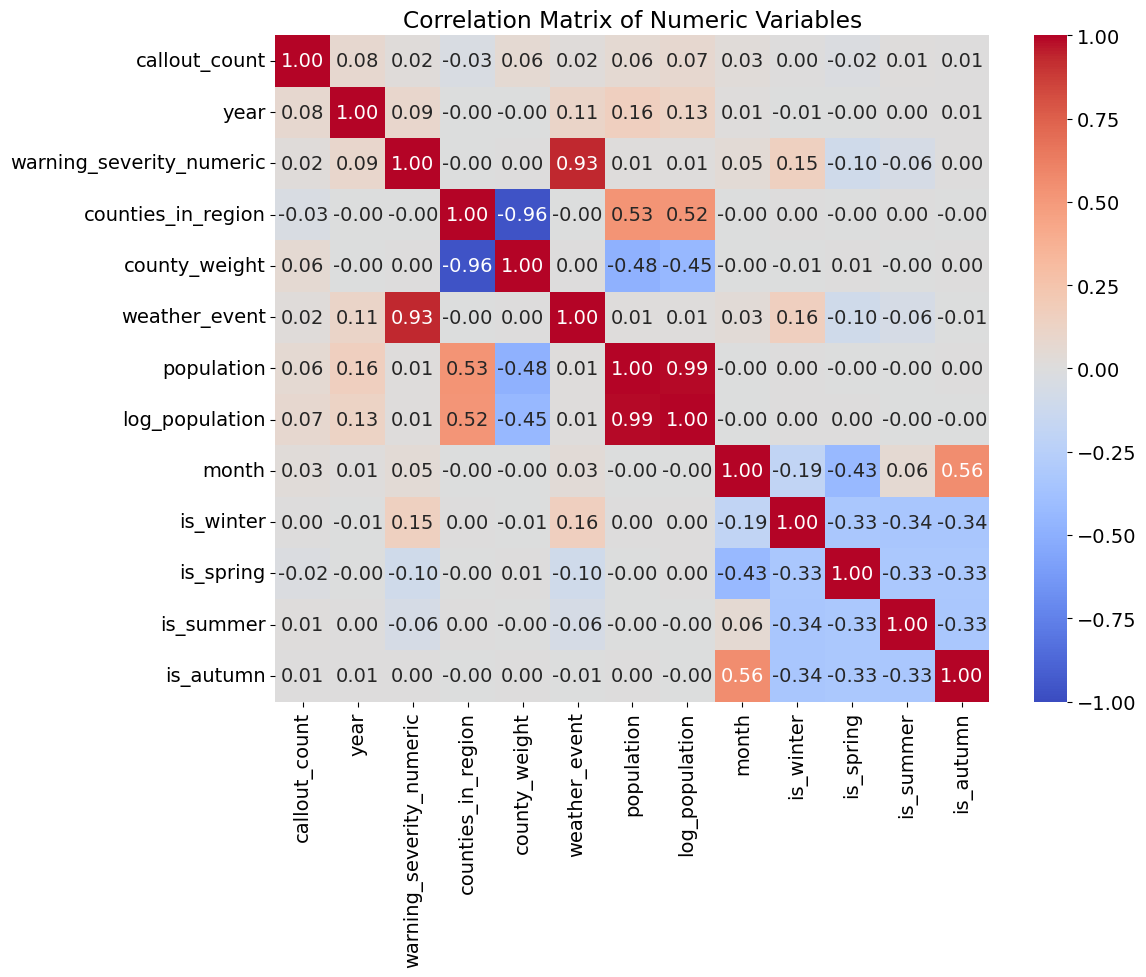

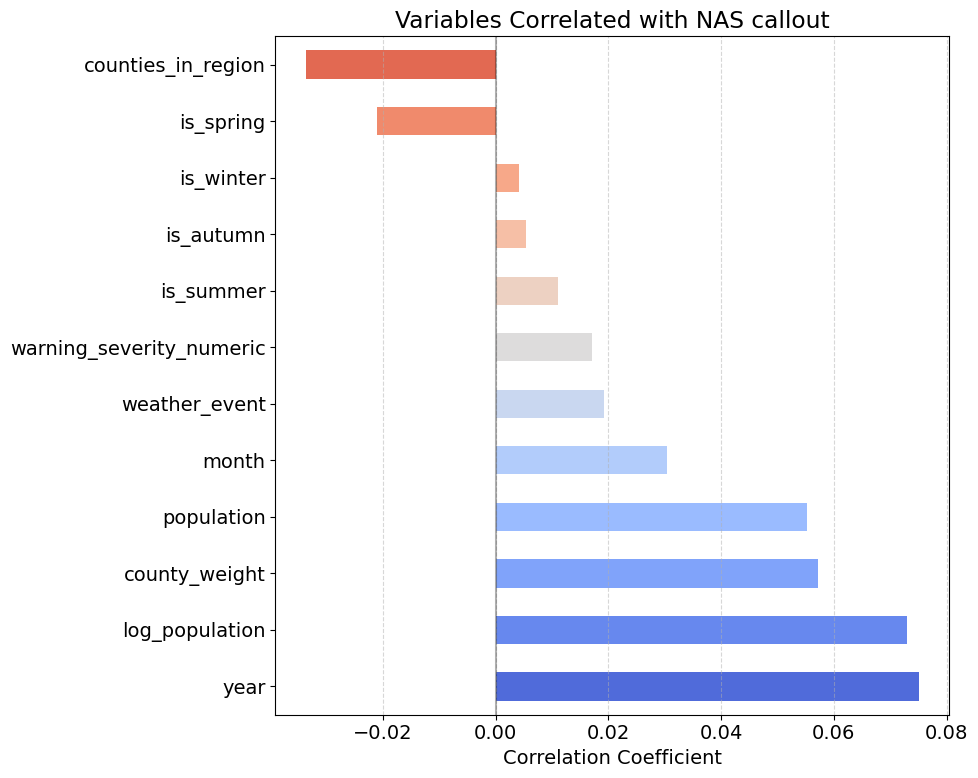

<Figure size 1500x1000 with 0 Axes>

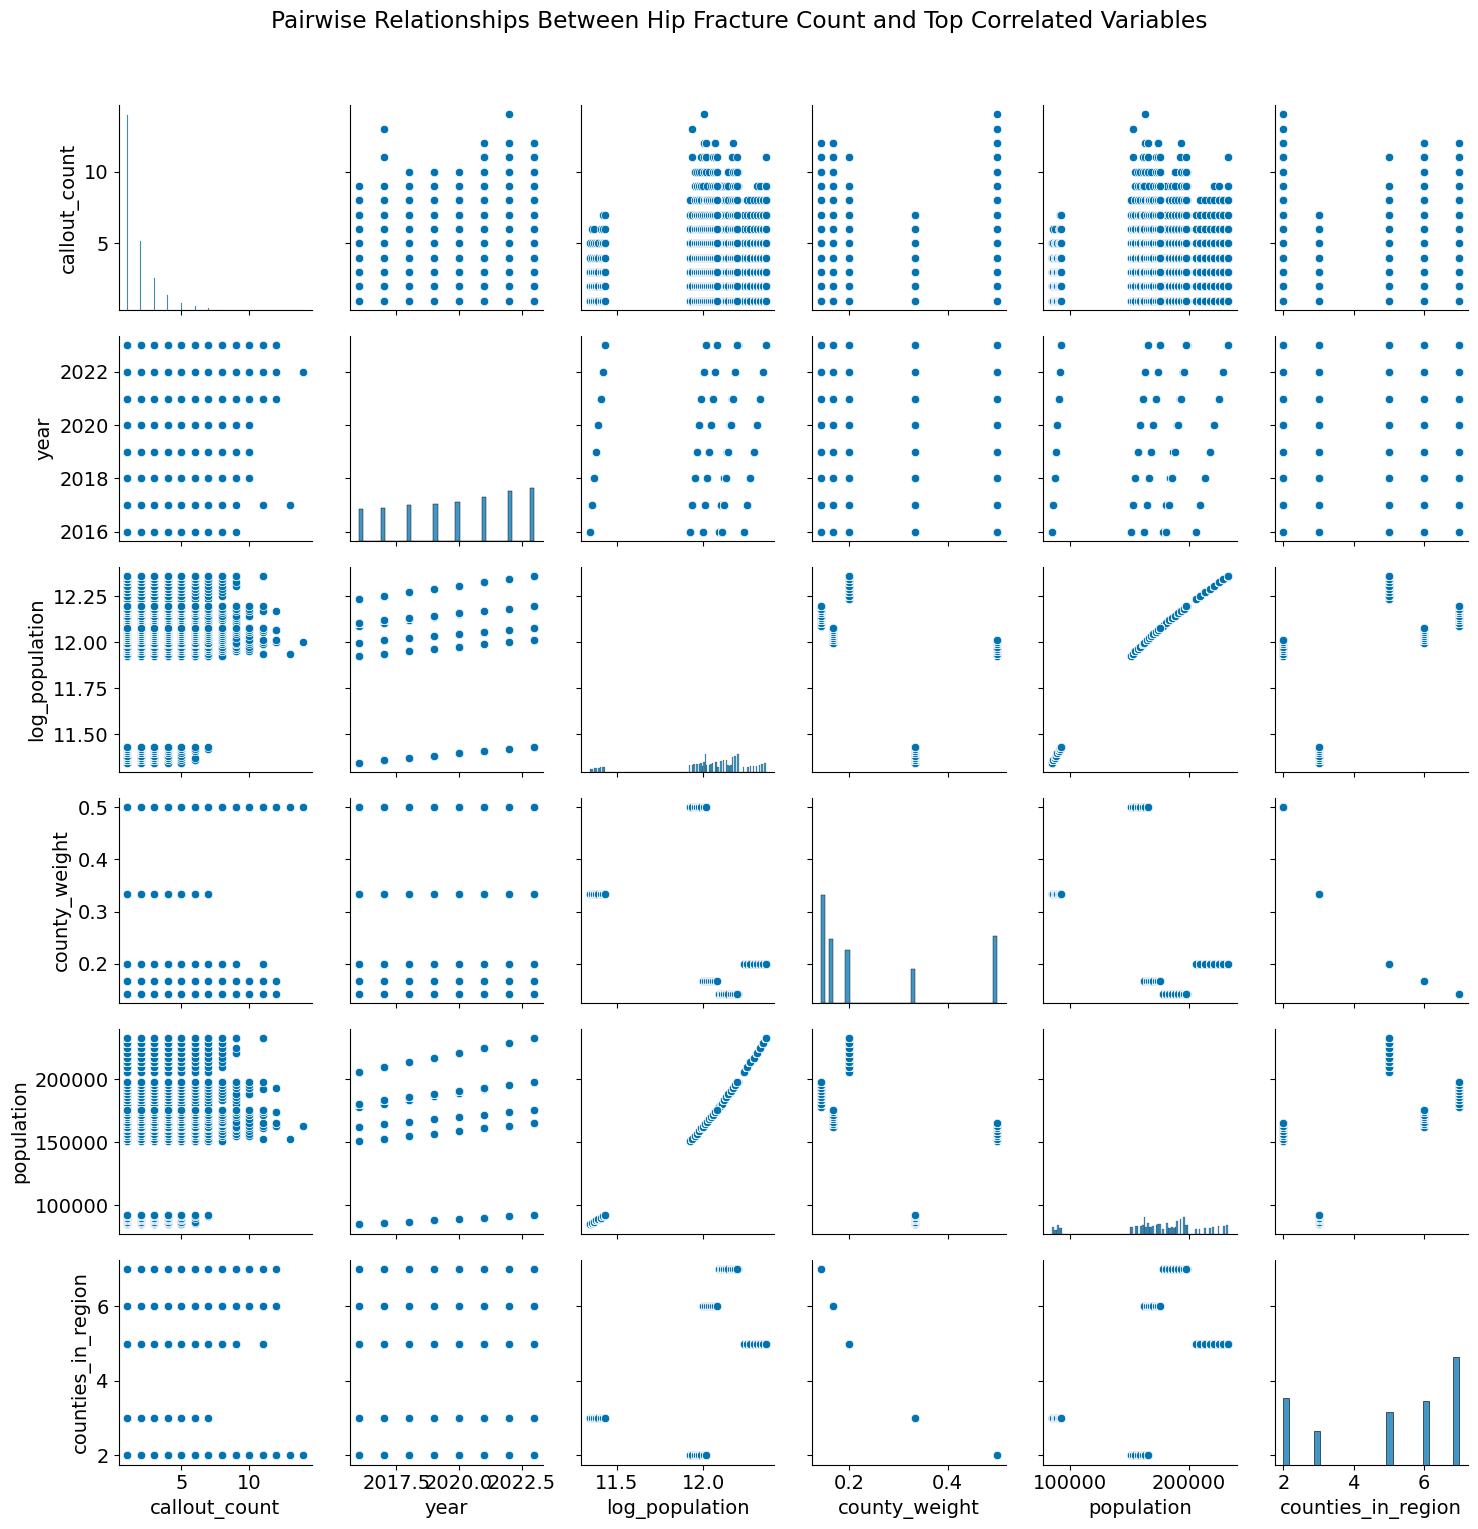

In [59]:
import matplotlib.pyplot as plt
numeric_cols = df_with_pop.select_dtypes(include=[np.number]).columns.tolist()

if 'callout_count' not in numeric_cols:
    print("Warning: callout_count not found in numeric columns")
else:
    # Create a correlation matrix
    corr_matrix = df_with_pop[numeric_cols].corr(method='pearson')
    
    # Sort correlations with hip_fracture_count
    hip_correlations = corr_matrix['callout_count'].sort_values(ascending=False)
    print("Correlations with NAS callout:")
    print(hip_correlations)
    
    # Plot heatmap of correlations
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Matrix of Numeric Variables')
    plt.tight_layout()
    plt.show()
    
    # Create a bar plot of correlations with hip_fracture_callout
    plt.figure(figsize=(10, 8))
    hip_correlations.drop('callout_count').plot(kind='barh', color=sns.color_palette("coolwarm", len(hip_correlations)))
    plt.title('Variables Correlated with NAS callout')
    plt.xlabel('Correlation Coefficient')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    # Optional: Create pairplots for top correlated variables
    top_correlated = hip_correlations.drop('callout_count').abs().nlargest(5).index.tolist()
    top_vars = ['callout_count'] + top_correlated
    
    plt.figure(figsize=(15, 10))
    sns.pairplot(df_with_pop[top_vars], height=2.5)
    plt.suptitle('Pairwise Relationships Between Hip Fracture Count and Top Correlated Variables', y=1.02)
    plt.tight_layout()
    plt.show()

In [60]:
df_with_pop.head()

,region,date,fall_category_group,callout_count,year,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event,population,log_population,month,season,is_winter,is_spring,is_summer,is_autumn
0,HSE Dublin and Midlands,2016-01-01,17A02_not_dangerous_proximal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0
1,HSE Dublin and Midlands,2016-01-01,17B00_bravo_override,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0
2,HSE Dublin and Midlands,2016-01-01,17B01_possibly_dangerous,3.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0
3,HSE Dublin and Midlands,2016-01-01,17D04_not_alert,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0
4,HSE Dublin and Midlands,2016-01-01,17D05_chest_neck_injury,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0


In [61]:
fall_category_counts = df_with_pop['fall_category_group'].value_counts()
print(fall_category_counts)

fall_category_group
17B01_possibly_dangerous              15965
17A02_not_dangerous_proximal          12584
17B00_bravo_override                  11478
17D04_not_alert                       11367
17A03_injuries_excluding_distal        6334
17A04_public_assistance                5750
30A03_traumatic_non_recent             5511
30B00_bravo_override_traumatic         3656
30B01_traumatic_possibly_dangerous     3634
17B04_unknown_status                   3597
30D03_traumatic_not_alert              1773
17D05_chest_neck_injury                1589
17B03_unknown_status                   1289
17B02_serious_haemorrhage              1247
17O01_not_dangerous_distal             1158
17D03_unconscious                       921
30A02_traumatic_proximal                760
17A01_not_dangerous_deformity           636
17D00_delta_override                    626
17O02_injuries_distal                   581
17D06_long_fall                         475
17D02_arrest                            294
30A01_trauma

In [62]:
def group_by_severity_codes(df, column='fall_category_group'):
    """
    Group fall categories by AMPDS severity codes
    
    AMPDS Severity Levels:
    - Alpha (A): Minor, not life-threatening
    - Bravo (B): Possibly serious, potentially life-threatening
    - Charlie (C): Serious, potentially life-threatening (not in your data)
    - Delta (D): Life-threatening, immediate response needed
    - Omega (O): Minor injuries/low priority (in your data as O)
    
    Additional codes:
    - 17: Falls
    - 30: Traumatic injuries
    """
    
    def categorize_by_severity(category):
        if pd.isna(category):
            return 'unknown'
        
        # Convert to string to handle any numeric values
        category = str(category)
        
        # Alpha codes (A) - Minor, not dangerous
        if 'A00' in category or 'A01' in category or 'A02' in category or 'A03' in category or 'A04' in category:
            # These are all "not dangerous" or "public assistance" calls
            return 'alpha_minor'
        
        # Bravo codes (B) - Possibly dangerous
        elif 'B00' in category or 'B01' in category or 'B02' in category or 'B03' in category or 'B04' in category:
            # These are "possibly dangerous" or "unknown status"
            return 'bravo_moderate'
        
        # Delta codes (D) - Life threatening
        elif 'D00' in category or 'D01' in category or 'D02' in category or 'D03' in category or 'D04' in category or 'D05' in category or 'D06' in category:
            # These include unconscious, not alert, extreme fall, arrest, etc.
            return 'delta_severe'
        
        # Omega codes (O) - Low priority/minor
        elif 'O01' in category or 'O02' in category:
            # Minor distal injuries
            return 'omega_minor'
        
        # If none of the above patterns match, try a different approach
        else:
            # Fallback: look at the descriptive part
            if 'not_dangerous' in category or 'minor' in category:
                return 'alpha_minor'
            elif 'possibly_dangerous' in category or 'unknown' in category:
                return 'bravo_moderate'
            elif 'not_alert' in category or 'unconscious' in category or 'arrest' in category or 'extreme' in category:
                return 'delta_severe'
            else:
                return 'other'
    
    # Create new column with severity grouping
    df['severity_group'] = df[column].apply(categorize_by_severity)
    
    # Create a more detailed grouping that considers both severity and type (17 vs 30)
    def detailed_categorize(category):
        if pd.isna(category):
            return 'unknown'
        
        category = str(category)
        
        # First determine if it's a fall (17) or traumatic injury (30)
        is_traumatic = category.startswith('30')
        
        # Then get severity
        if 'A0' in category or 'not_dangerous' in category:
            return 'traumatic_minor' if is_traumatic else 'fall_minor'
        elif 'B0' in category or 'possibly_dangerous' in category or 'unknown_status' in category:
            return 'traumatic_moderate' if is_traumatic else 'fall_moderate'
        elif 'D0' in category or 'not_alert' in category or 'unconscious' in category or 'extreme' in category or 'arrest' in category:
            return 'traumatic_severe' if is_traumatic else 'fall_severe'
        elif 'O0' in category:
            return 'fall_minor'  # Omega codes are only in fall category
        else:
            return 'other'
    
    # Create detailed grouping
    df['severity_group_detailed'] = df[column].apply(detailed_categorize)
    
    # Create a simplified 4-category grouping for modeling
    def simple_severity(category):
        if pd.isna(category):
            return 'unknown'
        
        category = str(category)
        
        # Keep the top 3 most frequent as separate categories
        if category == '17B01_possibly_dangerous':
            return '17B01_possibly_dangerous'
        elif category == '17A02_not_dangerous_proximal':
            return '17A02_not_dangerous_proximal'
        elif category == '17D04_not_alert':
            return '17D04_not_alert'
        # MUST CHECK TRAUMATIC FIRST (before checking for A0, B0, D0)
        elif category.startswith('30'):
            return 'traumatic_all'
        # Group all other alpha/omega codes - EXPANDED LIST
        elif any(code in category for code in ['A0', 'O0', 'not_dangerous', 'deformity', 'distal', 'public_assistance', 'alpha_override']):
            return 'minor_other'
        # Group all other bravo codes - EXPANDED LIST
        elif any(code in category for code in ['B0', 'possibly_dangerous', 'unknown', 'haemorrhage', 'bravo_override']):
            return 'moderate_other'
        # Group all other delta codes - EXPANDED LIST
        elif any(code in category for code in ['D0', 'not_alert', 'unconscious', 'extreme', 'arrest', 'chest_neck', 'delta_override', 'long_fall']):
            return 'severe_other'
        else:
            return 'other'
    
    df['severity_group_simple'] = df[column].apply(simple_severity)
    
    return df

# Apply the function
df_filtered = group_by_severity_codes(df_with_pop, column='fall_category_group')

# Display the distributions
print("Basic Severity Grouping:")
print(df_filtered['severity_group'].value_counts())
print("\nDetailed Severity Grouping (Fall vs Traumatic):")
print(df_filtered['severity_group_detailed'].value_counts())
print("\nSimplified Grouping for Modeling:")
print(df_filtered['severity_group_simple'].value_counts())

# Create a mapping table to show how categories were grouped
mapping_df = df_filtered[['fall_category_group', 'severity_group', 'severity_group_detailed', 'severity_group_simple']].drop_duplicates()
mapping_df = mapping_df.sort_values('fall_category_group')
print("\nMapping Table:")
print(mapping_df)



Basic Severity Grouping:
severity_group
bravo_moderate    40872
alpha_minor       31841
delta_severe      17204
omega_minor        1739
Name: count, dtype: int64

Detailed Severity Grouping (Fall vs Traumatic):
severity_group_detailed
fall_moderate         33576
fall_minor            27163
fall_severe           15305
traumatic_moderate     7296
traumatic_minor        6417
traumatic_severe       1899
Name: count, dtype: int64

Simplified Grouping for Modeling:
severity_group_simple
moderate_other                  17611
17B01_possibly_dangerous        15965
traumatic_all                   15612
minor_other                     14579
17A02_not_dangerous_proximal    12584
17D04_not_alert                 11367
severe_other                     3938
Name: count, dtype: int64

Mapping Table:
                     fall_category_group  severity_group  \
783                 17A00_alpha_override     alpha_minor   
51         17A01_not_dangerous_deformity     alpha_minor   
0           17A02_not_dang

In [63]:
import statsmodels
print(f"statsmodels version: {statsmodels.__version__}")

statsmodels version: 0.14.4


In [64]:
df_model_filtered = df_filtered[~df_filtered['severity_group_detailed'].isin(['fall_minor', 'traumatic_minor'])].copy()

print(f"Original dataset: {len(df_filtered)} observations")
print(f"After removing minor: {len(df_model_filtered)} observations")

Original dataset: 91656 observations
After removing minor: 58076 observations


In [65]:
unique_weather = df_model_filtered['warning_phenomenon'].unique()
for i, weather in enumerate(sorted(unique_weather), 1):
   print(f"{i}. {weather}")

print(f"\nTotal: {len(unique_weather)} different weather types")

1. Fog
2. Hail
3. High-Temperature
4. Ice
5. Low-Temperature
6. Low-Temperature_Ice
7. Rainfall
8. Snow_Ice
9. Thunder
10. Wind
11. no_weather_type

Total: 11 different weather types


In [66]:
df_model_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58076 entries, 1 to 91655
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   region                    58076 non-null  object        
 1   date                      58076 non-null  datetime64[ns]
 2   fall_category_group       58076 non-null  object        
 3   callout_count             58076 non-null  float64       
 4   year                      58076 non-null  int32         
 5   warning_phenomenon        58076 non-null  object        
 6   warning_severity          58076 non-null  object        
 7   warning_severity_numeric  58076 non-null  float64       
 8   counties_in_region        58076 non-null  int64         
 9   county_weight             58076 non-null  float64       
 10  weather_event             58076 non-null  float64       
 11  population                58076 non-null  int64         
 12  log_population         

In [67]:
df_model_filtered.to_csv('/home/paulharford/college/project/project_data/processed/WEATHERED_nas_merged_v2.csv', index=False)

FITTING POISSON MODEL (BASELINE)

Poisson Dispersion parameter: 0.6114
Interpretation: Strong underdispersion

Cameron-Trivedi test: statistic = -50.9827, p-value = 0.0000
Significant evidence against equidispersion at 5% level

RESIDUAL DIAGNOSTICS:
----------------------------------------
Pearson residuals - Mean: 0.0001, Std: 0.8371
Ljung-Box test p-value (lag 1): 0.0000

Poisson Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:          callout_count   No. Observations:                58034
Model:                            GLM   Df Residuals:                    57992
Model Family:                 Poisson   Df Model:                           41
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87704.
Date:                Fri, 01 Aug 2025   Deviance:                       35458.
Time:                        11:39:17   Pearso

/tmp/ipykernel_63008/2338885772.py:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gp_alpha = gp_results.params[-1]
/home/paulharford/anaconda3/envs/msc/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



GP alpha parameter: -0.1246
Negative alpha confirms underdispersion

Generalized Poisson Model Summary:
                    GeneralizedPoisson Regression Results                     
Dep. Variable:                      y   No. Observations:                58034
Model:             GeneralizedPoisson   Df Residuals:                    57992
Method:                           MLE   Df Model:                           41
Date:                Fri, 01 Aug 2025   Pseudo R-squ.:                 0.07607
Time:                        11:39:20   Log-Likelihood:                -86403.
converged:                       True   LL-Null:                       -93517.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

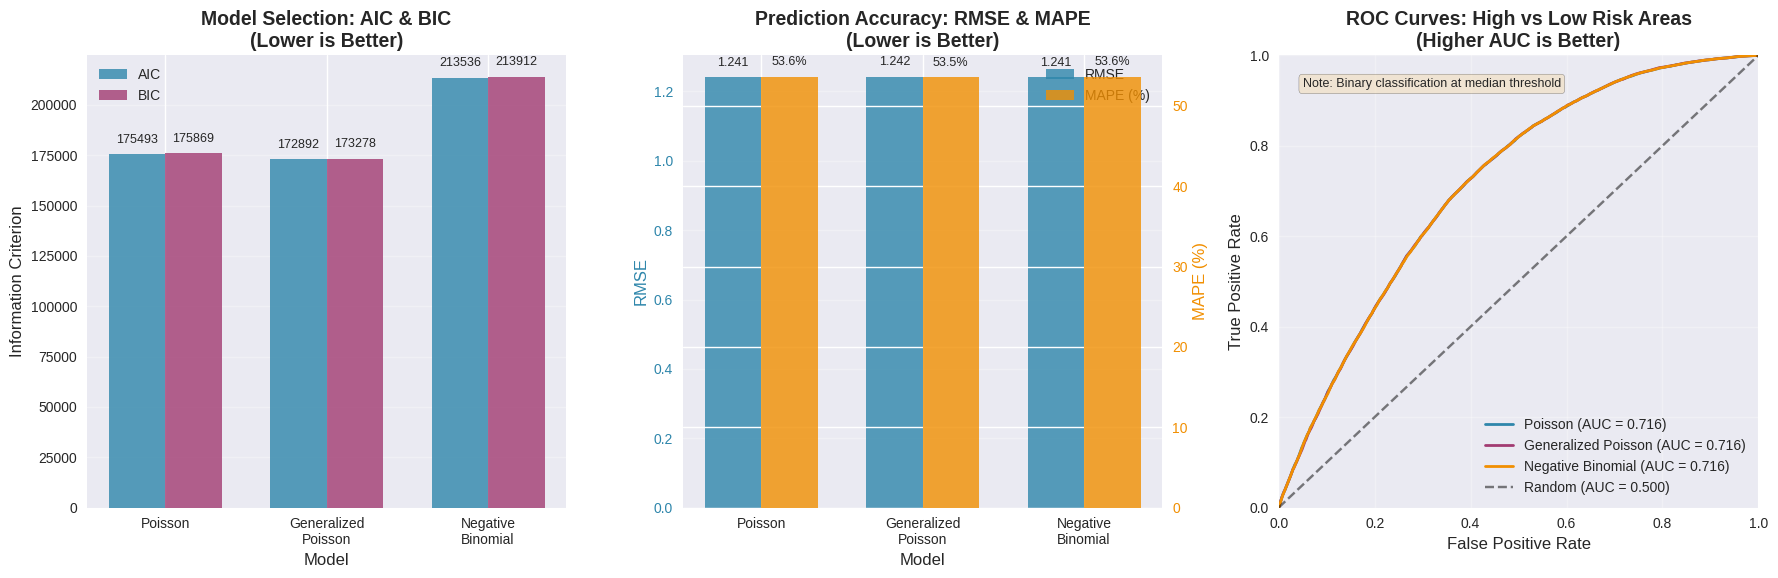


COMPREHENSIVE MODEL EVALUATION SUMMARY
              Model      AIC      BIC  RMSE   MAE  MAPE AUROC Within ±1 Within ±2 Pseudo R² Dispersion
            Poisson 175492.6 175869.3 1.241 0.886 53.6% 0.716     67.2%     92.3%     0.062      0.611
Generalized Poisson 172892.5 173278.1 1.242 0.884 53.5% 0.716     66.3%     92.2%     0.076        N/A
  Negative Binomial 213535.7 213912.4 1.241 0.887 53.6% 0.716     67.2%     92.3%     0.019        N/A

KEY INSIGHTS:

Best Model by Metric:
  AIC: Generalized Poisson
  BIC: Generalized Poisson
  RMSE: Poisson
  MAE: Generalized Poisson
  MAPE: Generalized Poisson
  Auroc: Poisson
  Within 1: Poisson
  Within 2: Poisson

Goodness-of-Fit Tests:
  Poisson: Pearson χ² p-value = 1.0000 (adequate fit)
  Generalized Poisson: Pearson χ² p-value = N/A
  Negative Binomial: Pearson χ² p-value = 1.0000 (adequate fit)

Dispersion Analysis:
  Poisson: Dispersion = 0.611

Creating evaluation plots...


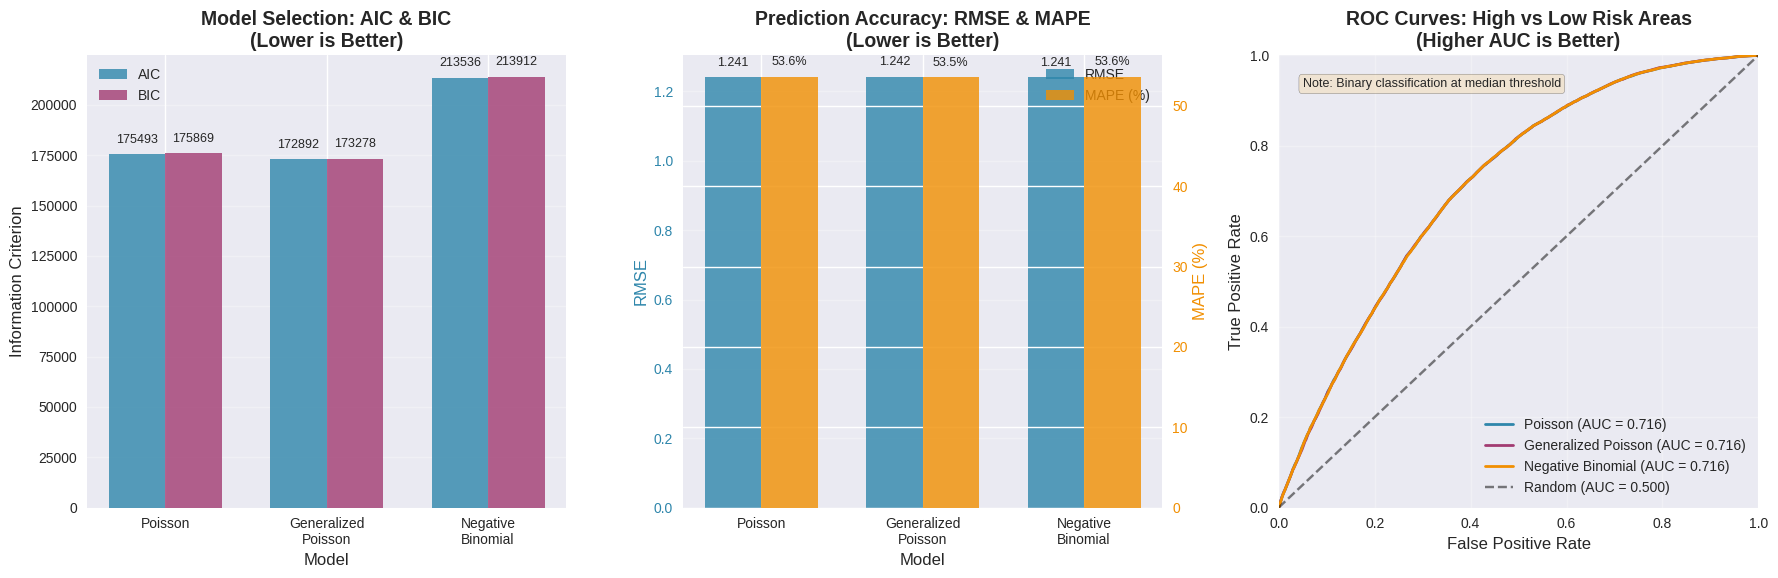

Plots saved as 'model_evaluation_plots.png' and 'model_evaluation_plots.pdf'

COMPREHENSIVE MODEL EVALUATION SUMMARY
              Model      AIC      BIC  RMSE   MAE  MAPE AUROC Within ±1 Within ±2 Pseudo R² Dispersion
            Poisson 175492.6 175869.3 1.241 0.886 53.6% 0.716     67.2%     92.3%     0.062      0.611
Generalized Poisson 172892.5 173278.1 1.242 0.884 53.5% 0.716     66.3%     92.2%     0.076        N/A
  Negative Binomial 213535.7 213912.4 1.241 0.887 53.6% 0.716     67.2%     92.3%     0.019        N/A

KEY INSIGHTS:

Best Model by Metric:
  AIC: Generalized Poisson
  BIC: Generalized Poisson
  RMSE: Poisson
  MAE: Generalized Poisson
  MAPE: Generalized Poisson
  Auroc: Poisson
  Within 1: Poisson
  Within 2: Poisson

Goodness-of-Fit Tests:
  Poisson: Pearson χ² p-value = 1.0000 (adequate fit)
  Generalized Poisson: Pearson χ² p-value = N/A
  Negative Binomial: Pearson χ² p-value = 1.0000 (adequate fit)

Dispersion Analysis:
  Poisson: Dispersion = 0.611


In [68]:
# Imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import patsy
from statsmodels.discrete.discrete_model import GeneralizedPoisson, NegativeBinomial, Poisson
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import acorr_ljungbox

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style for academic presentation
if 'seaborn-v0_8' in plt.style.available:
    plt.style.use('seaborn-v0_8')
else:
    plt.style.use('seaborn' if 'seaborn' in plt.style.available else 'default')

# Make a copy of your data
df_model = df_model_filtered.copy()
df_model['is_weekend'] = df_model['date'].dt.dayofweek.isin([5, 6]).astype(int)
df_model['day_of_week'] = df_model['date'].dt.dayofweek
df_model['callout_count_lag7'] = df_model.groupby('region')['callout_count'].shift(7)
df_model['is_cold_weather'] = df_model['warning_phenomenon'].isin([
    'Low-Temperature', 'Low-Temperature_Ice', 'Ice', 'Snow_Ice']).astype(int)
df_model['is_extreme_cold'] = (
    df_model['warning_phenomenon'].isin(['Low-Temperature_Ice', 'Ice']) &
    (df_model['warning_severity_numeric'] >= 2)  # Orange/Red only
).astype(int)
df_model_clean = df_model.dropna()

# Comprehensive model
y, X = patsy.dmatrices(
    "callout_count ~ "
    # Time effects
    "C(year, Treatment(reference=2017)) + "
    #"C(month, Treatment(reference=1)) + "
    "is_weekend + "
    # Location effects  
    "C(region, Treatment(reference='HSE Mid West')) + "
    # Fall severity effects
    "C(severity_group_detailed) + "
    "is_extreme_cold:C(severity_group_detailed) + "
    "is_winter:C(region, Treatment(reference='HSE Mid West')) + "
    "C(region, Treatment(reference='HSE Mid West')):C(severity_group_detailed) ",  # Regional variations
    data=df_model_clean,
    return_type='dataframe'
)

# Define the offset 
offset = df_model_clean.loc[y.index, "log_population"]

# Fit Poisson model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)
poisson_results = poisson_model.fit()

### 1. Fit Poisson Model 
print("="*60)
print("FITTING POISSON MODEL (BASELINE)")
print("="*60)

# Dispersion estimate and formal test
dispersion = poisson_results.deviance / poisson_results.df_resid
print(f"\nPoisson Dispersion parameter: {dispersion:.4f}")

# Interpret dispersion
if dispersion < 0.85:
    disp_interpretation = "Strong underdispersion"
elif dispersion < 0.95:
    disp_interpretation = "Mild underdispersion"
elif dispersion > 1.15:
    disp_interpretation = "Overdispersion"
else:
    disp_interpretation = "Approximate equidispersion"
print(f"Interpretation: {disp_interpretation}")

# Cameron & Trivedi dispersion test
def dispersion_test(model):
    """
    Cameron & Trivedi (1990) dispersion test
    H0: Equidispersion (var = mean)
    H1: Over/underdispersion
    """
    y = model.model.endog
    mu = model.fittedvalues
    
    # Correct auxiliary regression
    aux = ((y - mu)**2 - mu) / mu
    test_stat = np.sum(aux) / np.sqrt(2 * model.nobs)
    p_value = 2 * (1 - stats.norm.cdf(np.abs(test_stat)))
    
    return test_stat, p_value

test_stat, p_val = dispersion_test(poisson_results)
print(f"\nCameron-Trivedi test: statistic = {test_stat:.4f}, p-value = {p_val:.4f}")
if p_val < 0.05:
    print("Significant evidence against equidispersion at 5% level")

# Residual diagnostics
print("\nRESIDUAL DIAGNOSTICS:")
print("-" * 40)
pearson_resid = poisson_results.resid_pearson
print(f"Pearson residuals - Mean: {np.mean(pearson_resid):.4f}, Std: {np.std(pearson_resid):.4f}")

# Check for autocorrelation in residuals
ljung_box = acorr_ljungbox(pearson_resid, lags=10, return_df=True)
print(f"Ljung-Box test p-value (lag 1): {ljung_box['lb_pvalue'].iloc[0]:.4f}")
if ljung_box['lb_pvalue'].iloc[0] < 0.05:
    print("Warning: Significant autocorrelation detected in residuals")

print("\nPoisson Model Summary:")
print(poisson_results.summary())

### 2. Fit Generalized Poisson Model (For Underdispersion)
print("\n" + "="*60)
print("FITTING GENERALIZED POISSON MODEL (FOR UNDERDISPERSION)")
print("="*60)

# Convert y to 1D array
y_array = np.asarray(y).flatten()

try:
    gp_model = GeneralizedPoisson(endog=y_array, exog=X, offset=offset)
    gp_results = gp_model.fit(maxiter=1000, disp=False)
    
    # Extract and interpret alpha parameter
    gp_alpha = gp_results.params[-1]
    print(f"\nGP alpha parameter: {gp_alpha:.4f}")
    if gp_alpha < 0:
        print("Negative alpha confirms underdispersion")
    elif gp_alpha > 0:
        print("Positive alpha indicates overdispersion")
    
    print("\nGeneralized Poisson Model Summary:")
    print(gp_results.summary())
    gp_fitted = True
except Exception as e:
    print(f"\nGeneralized Poisson model failed: {e}")
    gp_fitted = False

### 3. Fit Negative Binomial Model (For Comparison)
print("\n" + "="*60)
print("FITTING NEGATIVE BINOMIAL MODEL (FOR COMPARISON)")
print("="*60)

try:
    nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial(), offset=offset)
    nb_results = nb_model.fit(disp=False)
    
    print("\nNegative Binomial Model Summary:")
    print(nb_results.summary())
    nb_fitted = True
except Exception as e:
    print(f"\nNegative Binomial model failed (expected for underdispersed data): {e}")
    nb_fitted = False

# Define evaluation functions
def calculate_aic_bic(model):
    """Calculate AIC and BIC for fitted model"""
    n = model.nobs
    k = len(model.params)  # Number of parameters
    log_lik = model.llf
    
    aic = 2 * k - 2 * log_lik
    bic = k * np.log(n) - 2 * log_lik
    
    return aic, bic

def calculate_prediction_metrics(y_true, y_pred, model=None):
    """Calculate various prediction metrics"""
    # Flatten arrays if needed
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    # MAPE 
    mask = y_true != 0
    zero_count = np.sum(~mask)
    if zero_count > 0:
        print(f"Warning: {zero_count} zero counts excluded from MAPE calculation")
    
    if np.sum(mask) > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    # Additional metrics
    residuals = y_true - y_pred
    within_1 = np.sum(np.abs(residuals) <= 1) / len(residuals) * 100
    within_2 = np.sum(np.abs(residuals) <= 2) / len(residuals) * 100
    
    # Correct Pearson chi-square calculation
    if model is not None and hasattr(model, 'pearson_chi2'):
        pearson_chi2 = model.pearson_chi2
        pearson_chi2_pvalue = 1 - stats.chi2.cdf(pearson_chi2, model.df_resid)
    else:
        # Manual calculation with protection
        if np.any(y_pred <= 0):
            print(f"Warning: {np.sum(y_pred <= 0)} zero or negative predictions found")
            y_pred_adj = np.maximum(y_pred, 0.0001)
            pearson_chi2 = np.sum((y_true - y_pred_adj)**2 / y_pred_adj)
        else:
            pearson_chi2 = np.sum((y_true - y_pred)**2 / y_pred)
        
        pearson_chi2_pvalue = np.nan
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'within_1': within_1,
        'within_2': within_2,
        'residuals': residuals,
        'pearson_chi2': pearson_chi2,
        'pearson_chi2_pvalue': pearson_chi2_pvalue
    }

def calculate_auroc_for_count_models(y_true, y_pred, threshold=None):
    """
    Calculate AUROC for count models by converting to binary classification.
    This measures the model's ability to distinguish between high-risk 
    (above median) and low-risk (below median) areas.
    
    Note: This is a secondary metric for count models and should be 
    interpreted with caution. It's useful for identifying areas that need
    more resources but doesn't capture the full count distribution.
    """
    # Flatten arrays
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    
    if threshold is None:
        threshold = np.median(y_true)  # Use true values for threshold
    
    # Convert to binary: high risk (1) vs low risk (0)
    y_true_binary = (y_true > threshold).astype(int)
    
    # Use predictions directly as scores for ROC curve
    try:
        auroc = roc_auc_score(y_true_binary, y_pred)
        fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
        return auroc, fpr, tpr
    except Exception as e:
        print(f"AUROC calculation failed: {e}")
        return np.nan, None, None

def calculate_pseudo_r2(model, y, X, offset):
    """Calculate McFadden's pseudo R-squared"""
    # Null model with intercept only
    null_model = sm.GLM(y, np.ones((len(y), 1)), 
                        family=model.family, 
                        offset=offset)
    null_results = null_model.fit()
    
    mcfadden_r2 = 1 - (model.llf / null_results.llf)
    return mcfadden_r2

# Evaluate the already fitted models
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

results = {}

# Extract predictions
y_true = np.asarray(y).flatten()

# 1. Evaluate Poisson
y_pred_poisson = poisson_results.predict()
aic_p, bic_p = calculate_aic_bic(poisson_results)
metrics_p = calculate_prediction_metrics(y_true, y_pred_poisson, poisson_results)
auroc_p, fpr_p, tpr_p = calculate_auroc_for_count_models(y_true, y_pred_poisson)
pseudo_r2_p = calculate_pseudo_r2(poisson_results, y, X, offset)

results['Poisson'] = {
    'aic': aic_p,
    'bic': bic_p,
    'log_likelihood': poisson_results.llf,
    **metrics_p,
    'auroc': auroc_p,
    'fpr': fpr_p,
    'tpr': tpr_p,
    'dispersion': dispersion,
    'pseudo_r2': pseudo_r2_p
}

# 2. Evaluate Generalized Poisson
if gp_fitted:
    y_pred_gp = gp_results.predict()
    aic_gp, bic_gp = calculate_aic_bic(gp_results)
    metrics_gp = calculate_prediction_metrics(y_true, y_pred_gp, gp_results)
    auroc_gp, fpr_gp, tpr_gp = calculate_auroc_for_count_models(y_true, y_pred_gp)
    
    # Calculate pseudo R² for GP
    try:
        null_gp = GeneralizedPoisson(endog=y_array, 
                                     exog=np.ones((len(y_array), 1)), 
                                     offset=offset).fit(disp=False)
        pseudo_r2_gp = 1 - (gp_results.llf / null_gp.llf)
    except:
        # If null model fails, use approximate calculation
        pseudo_r2_gp = np.nan
    
    results['Generalized Poisson'] = {
        'aic': aic_gp,
        'bic': bic_gp,
        'log_likelihood': gp_results.llf,
        **metrics_gp,
        'auroc': auroc_gp,
        'fpr': fpr_gp,
        'tpr': tpr_gp,
        'alpha': gp_alpha,
        'pseudo_r2': pseudo_r2_gp
    }

# 3. Evaluate Negative Binomial
if nb_fitted:
    y_pred_nb = nb_results.predict()
    aic_nb, bic_nb = calculate_aic_bic(nb_results)
    metrics_nb = calculate_prediction_metrics(y_true, y_pred_nb, nb_results)
    auroc_nb, fpr_nb, tpr_nb = calculate_auroc_for_count_models(y_true, y_pred_nb)
    pseudo_r2_nb = calculate_pseudo_r2(nb_results, y, X, offset)
    
    results['Negative Binomial'] = {
        'aic': aic_nb,
        'bic': bic_nb,
        'log_likelihood': nb_results.llf,
        **metrics_nb,
        'auroc': auroc_nb,
        'fpr': fpr_nb,
        'tpr': tpr_nb,
        'alpha': nb_results.scale if hasattr(nb_results, 'scale') else np.nan,
        'pseudo_r2': pseudo_r2_nb
    }

# Create evaluation plots
def create_evaluation_plots(results):
    """Create three separate plots for model evaluation"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    models = list(results.keys())
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # Plot 1: AIC/BIC Comparison
    ax1 = axes[0]
    x = np.arange(len(models))
    width = 0.35
    
    aic_values = [results[m]['aic'] for m in models]
    bic_values = [results[m]['bic'] for m in models]
    
    bars1 = ax1.bar(x - width/2, aic_values, width, label='AIC', color=colors[0], alpha=0.8)
    bars2 = ax1.bar(x + width/2, bic_values, width, label='BIC', color=colors[1], alpha=0.8)
    
    ax1.set_xlabel('Model', fontsize=12)
    ax1.set_ylabel('Information Criterion', fontsize=12)
    ax1.set_title('Model Selection: AIC & BIC\n(Lower is Better)', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.replace(' ', '\n') for m in models])
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for i, (aic, bic) in enumerate(zip(aic_values, bic_values)):
        ax1.text(i - width/2, aic + max(aic_values)*0.02, f'{aic:.0f}', 
                ha='center', va='bottom', fontsize=9)
        ax1.text(i + width/2, bic + max(bic_values)*0.02, f'{bic:.0f}', 
                ha='center', va='bottom', fontsize=9)
    
    # Plot 2: RMSE & MAPE Comparison
    ax2 = axes[1]
    
    rmse_values = [results[m]['rmse'] for m in models]
    mape_values = [results[m]['mape'] for m in models]
    
    # Create secondary y-axis for MAPE
    ax2_twin = ax2.twinx()
    
    bars1 = ax2.bar(x - width/2, rmse_values, width, label='RMSE', color=colors[0], alpha=0.8)
    bars2 = ax2_twin.bar(x + width/2, mape_values, width, label='MAPE (%)', color=colors[2], alpha=0.8)
    
    ax2.set_xlabel('Model', fontsize=12)
    ax2.set_ylabel('RMSE', fontsize=12, color=colors[0])
    ax2_twin.set_ylabel('MAPE (%)', fontsize=12, color=colors[2])
    ax2.set_title('Prediction Accuracy: RMSE & MAPE\n(Lower is Better)', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([m.replace(' ', '\n') for m in models])
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Color the y-axis labels
    ax2.tick_params(axis='y', labelcolor=colors[0])
    ax2_twin.tick_params(axis='y', labelcolor=colors[2])
    
    # Add values on bars
    for i, (rmse, mape) in enumerate(zip(rmse_values, mape_values)):
        ax2.text(i - width/2, rmse + max(rmse_values)*0.02, f'{rmse:.3f}', 
                ha='center', va='bottom', fontsize=9)
        ax2_twin.text(i + width/2, mape + max(mape_values)*0.02, f'{mape:.1f}%', 
                     ha='center', va='bottom', fontsize=9)
    
    # Add legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Plot 3: AUROC Comparison
    ax3 = axes[2]
    
    # Plot ROC curves
    for i, model in enumerate(models):
        if results[model]['fpr'] is not None and results[model]['tpr'] is not None:
            ax3.plot(results[model]['fpr'], results[model]['tpr'], 
                    label=f"{model} (AUC = {results[model]['auroc']:.3f})",
                    color=colors[i], linewidth=2)
    
    # Plot diagonal reference line
    ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC = 0.500)')
    
    ax3.set_xlabel('False Positive Rate', fontsize=12)
    ax3.set_ylabel('True Positive Rate', fontsize=12)
    ax3.set_title('ROC Curves: High vs Low Risk Areas\n(Higher AUC is Better)', fontsize=14, fontweight='bold')
    ax3.text(0.05, 0.95, 'Note: Binary classification at median threshold', 
             transform=ax3.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax3.legend(loc='lower right')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim([0, 1])
    ax3.set_ylim([0, 1])
    
    plt.tight_layout()
    return fig

def create_summary_table(results):
    """Create a comprehensive summary table"""
    
    summary_data = []
    for model, metrics in results.items():
        row_data = {
            'Model': model,
            'AIC': f"{metrics['aic']:.1f}",
            'BIC': f"{metrics['bic']:.1f}",
            'RMSE': f"{metrics['rmse']:.3f}",
            'MAE': f"{metrics['mae']:.3f}",
            'MAPE': f"{metrics['mape']:.1f}%",
            'AUROC': f"{metrics['auroc']:.3f}" if not np.isnan(metrics['auroc']) else "N/A",
            'Within ±1': f"{metrics['within_1']:.1f}%",
            'Within ±2': f"{metrics['within_2']:.1f}%"
        }
        
        # Add model-specific metrics
        if 'pseudo_r2' in metrics and not np.isnan(metrics['pseudo_r2']):
            row_data['Pseudo R²'] = f"{metrics['pseudo_r2']:.3f}"
        else:
            row_data['Pseudo R²'] = "N/A"
            
        if 'dispersion' in metrics:
            row_data['Dispersion'] = f"{metrics['dispersion']:.3f}"
        else:
            row_data['Dispersion'] = "N/A"
        
        summary_data.append(row_data)
    
    df_summary = pd.DataFrame(summary_data)
    
    # Print formatted table
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL EVALUATION SUMMARY")
    print("="*80)
    print(df_summary.to_string(index=False))
    print("="*80)
    
    # Additional insights
    print("\nKEY INSIGHTS:")
    
    # Best model by each metric
    print("\nBest Model by Metric:")
    
    # For metrics to minimize
    for metric in ['AIC', 'BIC', 'RMSE', 'MAE', 'MAPE']:
        values = []
        for m in results.keys():
            try:
                val = float(results[m][metric.lower()].rstrip('%') if isinstance(results[m][metric.lower()], str) else results[m][metric.lower()])
                values.append(val)
            except:
                values.append(np.inf)
        
        if len(values) > 0 and not all(np.isinf(values)):
            best_idx = np.argmin(values)
            best_model = list(results.keys())[best_idx]
            print(f"  {metric}: {best_model}")
    
    # For metrics to maximize
    for metric in ['AUROC', 'within_1', 'within_2']:
        values = []
        for m in results.keys():
            try:
                val = results[m][metric.lower()]
                values.append(val if not np.isnan(val) else -np.inf)
            except:
                values.append(-np.inf)
        
        if len(values) > 0 and not all(np.isinf(values)):
            best_idx = np.argmax(values)
            best_model = list(results.keys())[best_idx]
            print(f"  {metric.replace('_', ' ').title()}: {best_model}")
    
    # Report goodness-of-fit
    print("\nGoodness-of-Fit Tests:")
    for model in results.keys():
        if 'pearson_chi2_pvalue' in results[model]:
            p_val = results[model]['pearson_chi2_pvalue']
            if not np.isnan(p_val):
                print(f"  {model}: Pearson χ² p-value = {p_val:.4f}", end="")
                if p_val < 0.05:
                    print(" (poor fit)")
                else:
                    print(" (adequate fit)")
            else:
                print(f"  {model}: Pearson χ² p-value = N/A")
    
    # Report dispersion
    print("\nDispersion Analysis:")
    for model in results.keys():
        if 'dispersion' in results[model]:
            disp = results[model]['dispersion']
            print(f"  {model}: Dispersion = {disp:.3f}")
    
    return df_summary

# Create the plots
print("\nCreating evaluation plots...")
fig = create_evaluation_plots(results)

# Save the figure with high resolution for publication
fig.savefig('model_evaluation_plots.png', dpi=300, bbox_inches='tight')
fig.savefig('model_evaluation_plots.pdf', bbox_inches='tight')  # PDF for LaTeX
print("Plots saved as 'model_evaluation_plots.png' and 'model_evaluation_plots.pdf'")

plt.show()

# Create summary table
summary = create_summary_table(results)

# Save results for later use
model_comparison_results = {
    'results': results,
    'summary': summary,
    'models': {
        'poisson': poisson_results,
        'generalized_poisson': gp_results if gp_fitted else None,
        'negative_binomial': nb_results if nb_fitted else None
    }
}

# Create the plots
print("\nCreating evaluation plots...")
fig = create_evaluation_plots(results)
plt.show()

# Save the figure with high resolution for publication
fig.savefig('/home/paulharford/college/project/ul_project_Msc_AI/analysis/processed_data/visual_outputs/nas_weather/nas_model_evaluation_plots.png', dpi=300, bbox_inches='tight')
print("Plots saved as 'model_evaluation_plots.png' and 'model_evaluation_plots.pdf'")

# Create summary table
summary = create_summary_table(results)

# Save results for later use
model_comparison_results = {
    'results': results,
    'summary': summary,
    'models': {
        'poisson': poisson_results,
        'generalized_poisson': gp_results if gp_fitted else None,
        'negative_binomial': nb_results if nb_fitted else None
    }
}
